# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple direct marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

**Data Overview**: In the 17 telephone marketing campaigns that took place between May 2008 - November 2010, 79354 contacts were made with the objective of subscribing clients to a bank term deposit. Clients were offered a long-term deposit with interest, and a success rate of 0.08 was observed in the entire database. 

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [458]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from category_encoders import TargetEncoder

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
sns.set_palette("rocket")

In [436]:
pd.set_option("display.max_columns", None)
bank_df = pd.read_csv('/Users/lois/Downloads/ML ipynb/Module 17/data/bank-additional-full.csv', sep = ';')
print(bank_df.shape)
bank_df.head()

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```




#### Checking for missing values
There are no null values

In [437]:
bank_df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

#### Checking Datatypes
There are several categorical variables that will have to be encoded into numeric form. They are "job", "marital", "education", "default", "housing", "loan", "contact", "month", "day_of_week", and "poutcome".

In [438]:
bank_df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

**Business Objective**: The business objective is to predict whether an individual will subscribe to a term deposit or not, in order that marketing resources can be better distributed amongst and targeted towards clients more likely to subscribe. 

**Data Problem**: The data task is to fit and tune multiple classification models that group individuals into subscribers vs non-subscribers. The model(s) with high accuracy can be further studied for the most important features and feature values that characterize each of the two groups. These features are used for predicting whether a new individual will subscribe or not.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

#### Encoding Ordinal and Binary Columns  into Numeric Format 

In [439]:
#encoding education column
bank_df["education"].replace({"unknown" : 0, "illiterate" : 1, "high.school" : 2, "university.degree" : 3,
                         "basic.4y" : 4, "basic.6y" : 5, "basic.9y" : 6, "professional.course" : 7}, inplace = True)

#renaming y column (target variable) and changing it to numeric 
bank_df.rename({"y" : "subscribed"}, axis = 1, inplace = True)
bank_df["subscribed"].replace({"no" : 0, "yes" : 1}, inplace = True)

#### Target Encoding Nominal Columns

In [440]:
#creating a df with encoded columns
te = TargetEncoder()
encoded_df = te.fit_transform(df[["job", "marital", "default", "housing", "loan"]], df["subscribed"])

In [441]:
#combining encoded and original df 
bank_df.drop(["job", "marital", "default", "housing", "loan"], axis = 1, inplace = True)
bank_df = pd.concat([bank_df, encoded_df], axis = 1)
bank_df.shape

(41188, 21)

In [442]:
bank_df.dtypes

age                 int64
education           int64
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
subscribed          int64
job               float64
marital           float64
default           float64
housing           float64
loan              float64
dtype: object

#### Checking Distribution of Features

In [443]:
#checking skew
pd.DataFrame(bank_df.skew()).rename({0 : "Skew"}, axis = 1)

,Skew
age,0.784697
education,0.283121
duration,3.263141
campaign,4.762507
pdays,-4.922190
previous,3.832042
emp.var.rate,-0.724096
cons.price.idx,-0.230888
cons.conf.idx,0.303180
euribor3m,-0.709188


#### Transforming Columns with Skew of 3 or above

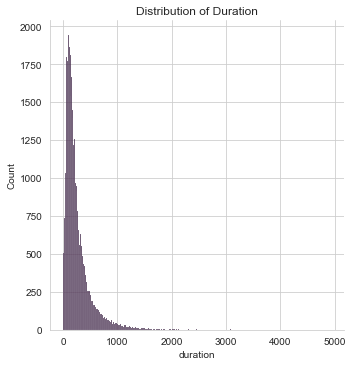

In [444]:
#checking distribution of duration
sns.displot(bank_df["duration"]).set(title = "Distribution of Duration")

[Text(0.5, 1.0, 'Log-Transformed Distribution of Duration')]

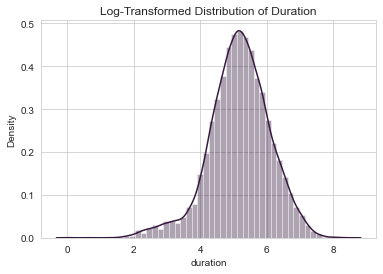

In [445]:
#log-transforming duration column
bank_df["duration"] = np.log1p(bank_df["duration"])
sns.distplot(bank_df['duration']).set(title = "Log-Transformed Distribution of Duration")

[Text(0.5, 1.0, 'Distribution of Campaign')]

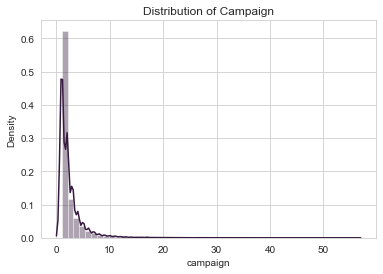

In [446]:
#checking distribution of campaign
sns.distplot(bank_df['campaign']).set(title = "Distribution of Campaign")

[Text(0.5, 1.0, 'Log-Transformed Distribution of Campaign')]

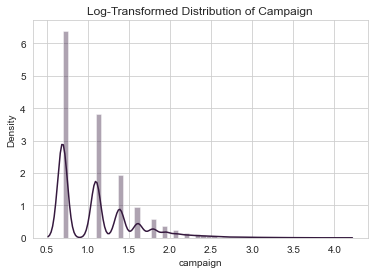

In [447]:
#log-transforming campaign
bank_df["campaign"] = np.log1p(bank_df["campaign"])
sns.distplot(bank_df['campaign']).set(title = "Log-Transformed Distribution of Campaign")

[Text(0.5, 1.0, 'Distribution of Pdays')]

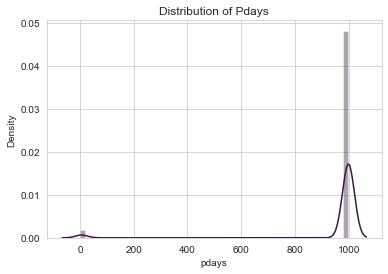

In [448]:
#checking distribution of pdays
sns.distplot(bank_df['pdays']).set(title = "Distribution of Pdays")

I will not be log-transforming the distribution of pdays because the value 999 means the client was not previously contacted, which means a high value no numeric significance. 

[Text(0.5, 1.0, 'Distribution of Previous')]

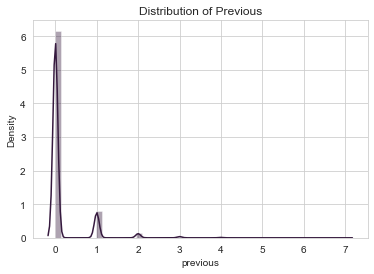

In [449]:
#checking distribution of previous
sns.distplot(bank_df['previous']).set(title = "Distribution of Previous")

[Text(0.5, 1.0, 'Log-Transformed Distribution of Previous')]

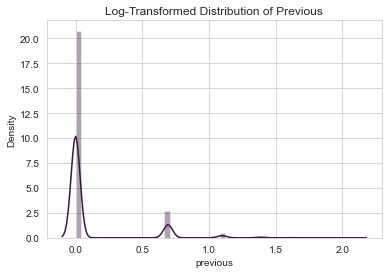

In [450]:
#log-transforming previous 
bank_df["previous"] = np.log1p(bank_df["previous"])
sns.distplot(bank_df['previous']).set(title = "Log-Transformed Distribution of Previous")

In [451]:
bank_df.skew()

age               0.784697
education         0.283121
duration         -0.421327
campaign          1.350403
pdays            -4.922190
previous          2.587040
emp.var.rate     -0.724096
cons.price.idx   -0.230888
cons.conf.idx     0.303180
euribor3m        -0.709188
nr.employed      -1.044262
subscribed        2.450330
job               2.372102
marital           0.964322
default          -1.433478
housing          -0.098167
loan             -1.757183
dtype: float64

#### Correlation Analysis
The columns most positively correlated with "subscribed" are "duration", "previous", job

The columns most negatively correlated with "subscribed" are "pdays", "emp.var.rate", "euribor3m", "nr.employed"

There are multiple instances of high multicollinearity (0.5 or greater): 
- pdays and previous
- previous and nr.employed
- emp.var.rate and cons.price.idx
- emp.var.rate and euribor3m
- emp.var.rate and nr.employed 
- cons.price.idx and euribor3m
- cons.price.idx and nr.employed
- euribor3m and nr.employed 

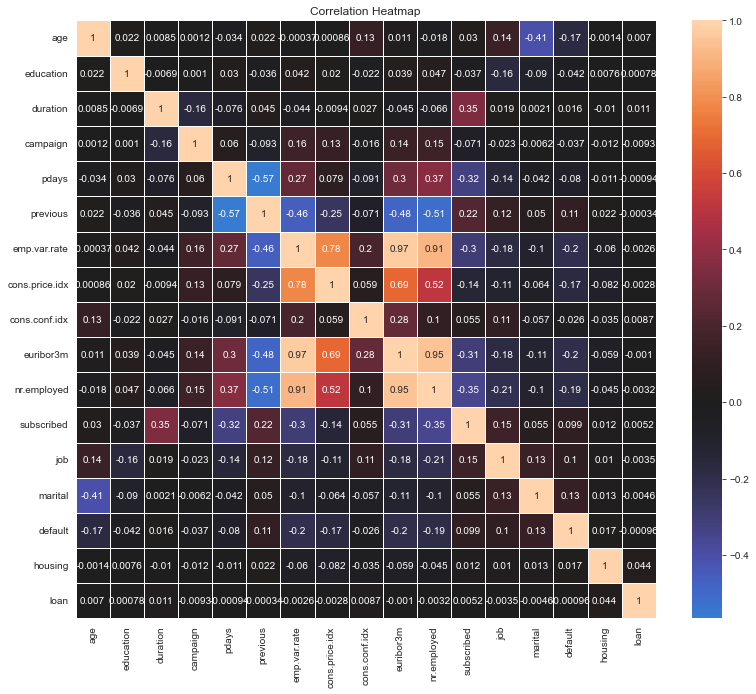

In [455]:
#correlation heatmap  
sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(13, 11))

sns.heatmap(bank_df.corr(), center = 0, linewidth = .5, annot = True).set(title='Correlation Heatmap');

### Creating the final dataframe
Using SequentialFeatureSelection to select the top 7 features for training models. The estimator chosen is Logistic Regression and 5-fold cross validation is implemented. The scoring metric used is accuracy because this a classification task and we want our predictive model to maximize the number of correct predictions. 

The top 7 features are age, duration, campaign, pdays, nr.employed, marital, default. These features do not exhibit multicollinearity with each other and will constitute the final df. 

In [462]:
#subsetting the dataframe to numeric values
df_num = bank_df.drop(["contact", "month", "day_of_week", "poutcome"], axis = 1)

In [465]:
X = df_num.drop("subscribed", axis = 1)
y = df_num["subscribed"]

In [466]:
#SequentialFeatureSelection
sfs = SequentialFeatureSelector(estimator = LogisticRegression(),
                               scoring = "neg_mean_squared_error",
                               cv = 5,
                               n_features_to_select = 7)

sfs.fit(X, y)

SequentialFeatureSelector(estimator=LogisticRegression(),
                          n_features_to_select=7,
                          scoring='neg_mean_squared_error')

In [467]:
#getting results
sfs.get_feature_names_out(input_features=None)

array(['age', 'duration', 'campaign', 'pdays', 'nr.employed', 'marital',
       'default'], dtype=object)

In [468]:
#constructing final df
df = bank_df[["age", "duration", "campaign", "pdays", "nr.employed", "marital", "default", "subscribed"]]

#### Visualizing the Distribution of "subscribed" 
This is an imbalanced dataset, with the vast majority of people rejecting the subscription offer.

Text(0.5, 1.0, 'Subscriptoin Counts')

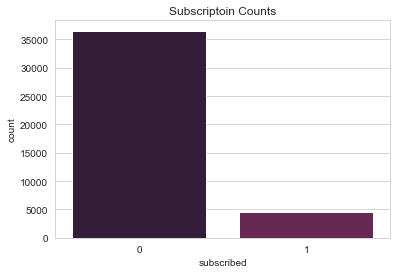

In [470]:
sns.countplot(data = df, x = df["subscribed"]).set_title("Subscriptoin Counts")

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [471]:
X = df.drop("subscribed", axis = 1)
y = df["subscribed"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

The baseline accuracy for a model that predicts the majority for all data points is **0.89**

In [474]:
#baseline score for the model that predicts the majority class for all data points
y_test.value_counts(normalize = True)[0]

0.8875940762320952

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [475]:
#fitting logistic regression model 
logreg = LogisticRegression()
start = time.time()
logreg.fit(X_train, y_train)
stop = time.time()
log_time = stop - start

In [476]:
logreg_train_preds = logreg.predict(X_train)
logreg_test_preds = logreg.predict(X_test)
logreg_train_acc = accuracy_score(logreg_train_preds, y_train)
logreg_test_acc = accuracy_score(logreg_test_preds, y_test)

### Problem 9: Score the Model

The accuracy of the Logistic Regression model is **0.911**.

In [477]:
print(f"Logistic Regression Accuracy Score: {np.round(log_acc, 3)}")

Logistic Regression Accuracy Score: 0.911


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

#### KNN Model

In [478]:
#training the knn model 
knn = KNeighborsClassifier()
start = time.time()
knn.fit(X_train, y_train)
stop = time.time()
knn_time = stop - start

In [479]:
knn_train_preds = knn.predict(X_train)
knn_test_preds = knn.predict(X_test)
knn_train_acc = accuracy_score(knn_train_preds, y_train)
knn_test_acc = accuracy_score(knn_test_preds, y_test)

#### Decision Tree Model 

In [480]:
dtree = DecisionTreeClassifier()
start = time.time()
dtree.fit(X_train, y_train)
stop = time.time()
dtree_time = stop - start

In [481]:
tree_train_preds = dtree.predict(X_train)
tree_test_preds = dtree.predict(X_test)
tree_train_acc = accuracy_score(tree_train_preds, y_train)
tree_test_acc = accuracy_score(tree_test_preds, y_test)

#### SVM Model

In [482]:
svc = SVC()
start = time.time()
svc.fit(X_train, y_train)
stop = time.time()
svc_time = stop - start

In [483]:
svc_train_preds = svc.predict(X_train)
svc_test_preds = svc.predict(X_test)
svc_train_acc = accuracy_score(svc_train_preds, y_train)
svc_test_acc = accuracy_score(svc_test_preds, y_test)

#### Building the Table

In [484]:
data = {"Model" : ["Logistic Regression", "KNN", "Decision Tree", "SVC"],
        "Train Time" : [log_time, knn_time, dtree_time, svc_time],
        "Train Accuracy" : [logreg_train_acc, knn_train_acc, tree_train_acc, svc_train_acc],
        "Test Accuracy" : [logreg_test_acc, knn_test_acc, tree_test_acc, svc_test_acc]}

In [485]:
results_df = pd.DataFrame(data).set_index("Model")
results_df

,Train Time,Train Accuracy,Test Accuracy
Model,,,
Logistic Regression,0.121969,0.905935,0.906612
KNN,0.019707,0.927925,0.898762
Decision Tree,0.060404,0.999168,0.880149
SVC,8.866257,0.897818,0.896820


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

#### Feature Engineering and Exploration
The original df did not have a gender feature.

#### GridSearchCV for the four models
- Hyperparameter tuning

#### Performance Metric Rationale 
- The original performance metric was accuracy because we wanted to maximize the number of correct predictions. A second alternative is precision because the business objective is to accurately identify subscribers. 

#### Conclusion
- Review the UCI site to see what the columns mean (day of week and such)